We have 70 observations with 319 dimensions


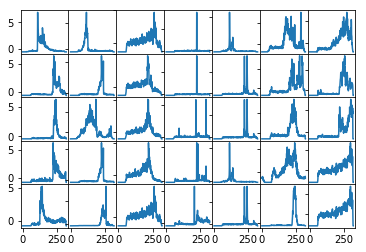

Train with approximately 2742 epochs
INFO:tensorflow:Summary name cross entropy_loss is illegal; using cross_entropy_loss instead.
INFO:tensorflow:Summary name Conv_Layer_1:0 is illegal; using Conv_Layer_1_0 instead.
INFO:tensorflow:Summary name Conv_Layer_1:0/gradients is illegal; using Conv_Layer_1_0/gradients instead.
INFO:tensorflow:Summary name Conv_Layer_1:0/gradient_norm is illegal; using Conv_Layer_1_0/gradient_norm instead.
INFO:tensorflow:Summary name Conv1/bias_for_Conv_Layer_1:0 is illegal; using Conv1/bias_for_Conv_Layer_1_0 instead.
INFO:tensorflow:Summary name Conv1/bias_for_Conv_Layer_1:0/gradients is illegal; using Conv1/bias_for_Conv_Layer_1_0/gradients instead.
INFO:tensorflow:Summary name Conv1/bias_for_Conv_Layer_1:0/gradient_norm is illegal; using Conv1/bias_for_Conv_Layer_1_0/gradient_norm instead.
INFO:tensorflow:Summary name BatchNorm/beta:0 is illegal; using BatchNorm/beta_0 instead.
INFO:tensorflow:Summary name BatchNorm/beta:0/gradients is illegal; using Bat

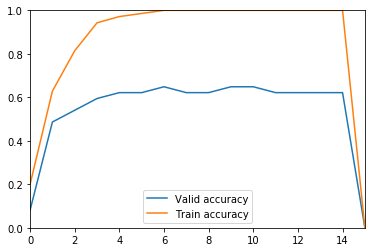

In [17]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 22 10:43:29 2016

@author: Rob Romijnders
"""
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from tensorflow.python.ops import clip_ops

tf.reset_default_graph()
"""Hyperparameters"""
num_filt_1 = 16     #Number of filters in first conv layer
num_filt_2 = 14     #Number of filters in second conv layer
num_filt_3 = 8      #Number of filters in thirs conv layer
num_fc_1 = 40       #Number of neurons in hully connected layer
max_iterations = 3000
batch_size = 64
dropout = 1.0       #Dropout rate in the fully connected layer
plot_row = 5        #How many rows do you want to plot in the visualization
learning_rate = 2e-5
input_norm = False   # Do you want z-score input normalization?

"""Load the data"""

data_train = np.loadtxt('Lightning7/Lighting7_TRAIN.txt',delimiter=',')
data_test_val = np.loadtxt('Lightning7/Lighting7_TEST.txt',delimiter=',')
data_test,data_val = data_test_val[:36,:], data_test_val[36:,:]
# Usually, the first column contains the target labels
X_train = data_train[:,1:]
X_val = data_val[:,1:]
X_test = data_test[:,1:]
N = X_train.shape[0]
Ntest = X_test.shape[0]
D = X_train.shape[1]
y_train = data_train[:,0]
y_val = data_val[:,0]
y_test = data_test[:,0]
print('We have %s observations with %s dimensions'%(N,D))
# Organize the classes
num_classes = len(np.unique(y_train))
base = np.min(y_train)  #Check if data is 0-based
if base != 0:
    y_train -=base
    y_val -= base
    y_test -= base

if input_norm:
    mean = np.mean(X_train,axis=0)
    variance = np.var(X_train,axis=0)
    X_train -= mean
    #The 1e-9 avoids dividing by zero
    X_train /= np.sqrt(variance)+1e-9
    X_val -= mean
    X_val /= np.sqrt(variance)+1e-9
    X_test -= mean
    X_test /= np.sqrt(variance)+1e-9



if True:  #Set true if you want to visualize the actual time-series
    f, axarr = plt.subplots(plot_row, num_classes)
    for c in np.unique(y_train):    #Loops over classes, plot as columns
        ind = np.where(y_train == c)
        ind_plot = np.random.choice(ind[0],size=plot_row)
        for n in range(plot_row):  #Loops over rows
            c = int(c)
            axarr[n,c].plot(X_train[ind_plot[n],:])
            # Only shops axes for bottom row and left column
            if not n == plot_row-1:
                plt.setp([axarr[n,c].get_xticklabels()], visible=False)
            if not c == 0:
                plt.setp([axarr[n,c].get_yticklabels()], visible=False)
    f.subplots_adjust(hspace=0)  #No horizontal space between subplots
    f.subplots_adjust(wspace=0)  #No vertical space between subplots
    plt.show()


#Check for the input sizes
#assert (N>X_train.shape[1]), 'You are feeding a fat matrix for training, are you sure?'
#assert (Ntest>X_test.shape[1]), 'You are feeding a fat matrix for testing, are you sure?'

#Proclaim the epochs
epochs = np.floor(batch_size*max_iterations / N)
print('Train with approximately %d epochs' %(epochs))

# Nodes for the input variables
x = tf.placeholder("float", shape=[None, D], name = 'Input_data')
y_ = tf.placeholder(tf.int64, shape=[None], name = 'Ground_truth')
keep_prob = tf.placeholder("float")
bn_train = tf.placeholder(tf.bool)          #Boolean value to guide batchnorm

# Define functions for initializing variables and standard layers
#For now, this seems superfluous, but in extending the code
#to many more layers, this will keep our code
#read-able

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name = name)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

with tf.name_scope("Reshaping_data") as scope:
  x_image = tf.reshape(x, [-1,D,1,1])

initializer = tf.contrib.layers.xavier_initializer()
"""Build the graph"""
# ewma is the decay for which we update the moving average of the
# mean and variance in the batch-norm layers
with tf.name_scope("Conv1") as scope:
  W_conv1 = tf.get_variable("Conv_Layer_1", shape=[5, 1, 1, num_filt_1],initializer=initializer)
  b_conv1 = bias_variable([num_filt_1], 'bias_for_Conv_Layer_1')
  a_conv1 = conv2d(x_image, W_conv1) + b_conv1

with tf.name_scope('Batch_norm_conv1') as scope:
    a_conv1 = tf.contrib.layers.batch_norm(a_conv1,is_training=bn_train,updates_collections=None)
    h_conv1 = tf.nn.relu(a_conv1)

with tf.name_scope("Conv2") as scope:
  W_conv2 = tf.get_variable("Conv_Layer_2", shape=[4, 1, num_filt_1, num_filt_2],initializer=initializer)
  b_conv2 = bias_variable([num_filt_2], 'bias_for_Conv_Layer_2')
  a_conv2 = conv2d(h_conv1, W_conv2) + b_conv2

with tf.name_scope('Batch_norm_conv2') as scope:
    a_conv2 = tf.contrib.layers.batch_norm(a_conv2,is_training=bn_train,updates_collections=None)
    h_conv2 = tf.nn.relu(a_conv2)

with tf.name_scope("Fully_Connected1") as scope:
  W_fc1 = tf.get_variable("Fully_Connected_layer_1", shape=[D*num_filt_2, num_fc_1],initializer=initializer)
  b_fc1 = bias_variable([num_fc_1], 'bias_for_Fully_Connected_Layer_1')
  h_conv3_flat = tf.reshape(h_conv2, [-1, D*num_filt_2])
  h_fc1 = tf.nn.relu(tf.matmul(h_conv3_flat, W_fc1) + b_fc1)

with tf.name_scope("Fully_Connected2") as scope:
  h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
  W_fc2 = tf.get_variable("W_fc2", shape=[num_fc_1, num_classes],initializer=initializer)
  b_fc2 = tf.Variable(tf.constant(0.1, shape=[num_classes]),name = 'b_fc2')
  h_fc2 = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

with tf.name_scope("SoftMax") as scope:
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h_fc2,labels=y_)
    cost = tf.reduce_sum(loss) / batch_size
    loss_summ = tf.summary.scalar("cross entropy_loss", cost)
with tf.name_scope("train") as scope:
    tvars = tf.trainable_variables()
    #We clip the gradients to prevent explosion
    grads = tf.gradients(cost, tvars)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    gradients = list(zip(grads, tvars))
    train_step = optimizer.apply_gradients(gradients)
    # The following block plots for every trainable variable
    #  - Histogram of the entries of the Tensor
    #  - Histogram of the gradient over the Tensor
    #  - Histogram of the grradient-norm over the Tensor
    numel = tf.constant([[0]])
    for gradient, variable in gradients:
      if isinstance(gradient, ops.IndexedSlices):
        grad_values = gradient.values
      else:
        grad_values = gradient

      numel +=tf.reduce_sum(tf.size(variable))

      h1 = tf.summary.histogram(variable.name, variable)
      h2 = tf.summary.histogram(variable.name + "/gradients", grad_values)
      h3 = tf.summary.histogram(variable.name + "/gradient_norm", clip_ops.global_norm([grad_values]))
with tf.name_scope("Evaluating_accuracy") as scope:
    correct_prediction = tf.equal(tf.argmax(h_fc2,1), y_)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    accuracy_summary = tf.summary.scalar("accuracy", accuracy)


#Define one op to call all summaries
merged = tf.summary.merge_all()

def print_tvars():
  tvars = tf.trainable_variables()
  for variable in tvars:
    print(variable.name)
  return
print_tvars()

# For now, we collect performances in a Numpy array.
# In future releases, I hope TensorBoard allows for more
# flexibility in plotting
perf_collect = np.zeros((3,int(np.floor(max_iterations /100))))
cost_ma = 0.0
acc_ma = 0.0
with tf.Session() as sess:
  writer = tf.summary.FileWriter("./log_tb", sess.graph)

  sess.run(tf.global_variables_initializer())

  step = 0      # Step is a counter for filling the numpy array perf_collect
  for i in range(max_iterations):
    batch_ind = np.random.choice(N,batch_size,replace=False)

    if i==0:
        # Use this line to check before-and-after test accuracy
        result = sess.run(accuracy, feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
        acc_test_before = result
    if i%200 == 0:
      #Check training performance
      result = sess.run([cost,accuracy],feed_dict = { x: X_train, y_: y_train, keep_prob: 1.0, bn_train : False})
      perf_collect[1,step] = acc_train = result[1]
      cost_train = result[0]

      #Check validation performance
      result = sess.run([accuracy,cost,merged], feed_dict={ x: X_val, y_: y_val, keep_prob: 1.0, bn_train : False})
      perf_collect[0,step] = acc_val = result[0]
      cost_val = result[1]
      if i == 0: cost_ma = cost_train
      if i == 0: acc_ma = acc_train
      cost_ma = 0.8*cost_ma+0.2*cost_train
      acc_ma = 0.8*acc_ma + 0.2*acc_train

      #Write information to TensorBoard
      writer.add_summary(result[2], i)
      writer.flush()  #Don't forget this command! It makes sure Python writes the summaries to the log-file
      print("At %5.0f/%5.0f Cost: train%5.3f val%5.3f Acc: train%5.3f val%5.3f " % (i,max_iterations, cost_train,cost_val,acc_train,acc_val))
      step +=1
    sess.run(train_step,feed_dict={x:X_train[batch_ind], y_: y_train[batch_ind], keep_prob: dropout, bn_train : True})
  result = sess.run([accuracy,numel], feed_dict={ x: X_test, y_: y_test, keep_prob: 1.0, bn_train : False})
  acc_test = result[0]
  print('The network has %s trainable parameters'%(result[1]))

"""Additional plots"""
print('The accuracy on the test data is %.3f, before training was %.3f' %(acc_test,acc_test_before))
plt.figure()
plt.plot(perf_collect[0],label='Valid accuracy')
plt.plot(perf_collect[1],label = 'Train accuracy')
plt.axis([0, step, 0, np.max(perf_collect)])
plt.legend()
plt.show()
# We can now open TensorBoard. Run the following line from your terminal
# tensorboard --logdir=./log_tb